In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange

import os
os.makedirs('Figure_2', exist_ok=True)

# FIGURE 2
### Genes associated with neuronal differentiation are differentially expressed along the principal imaging axis

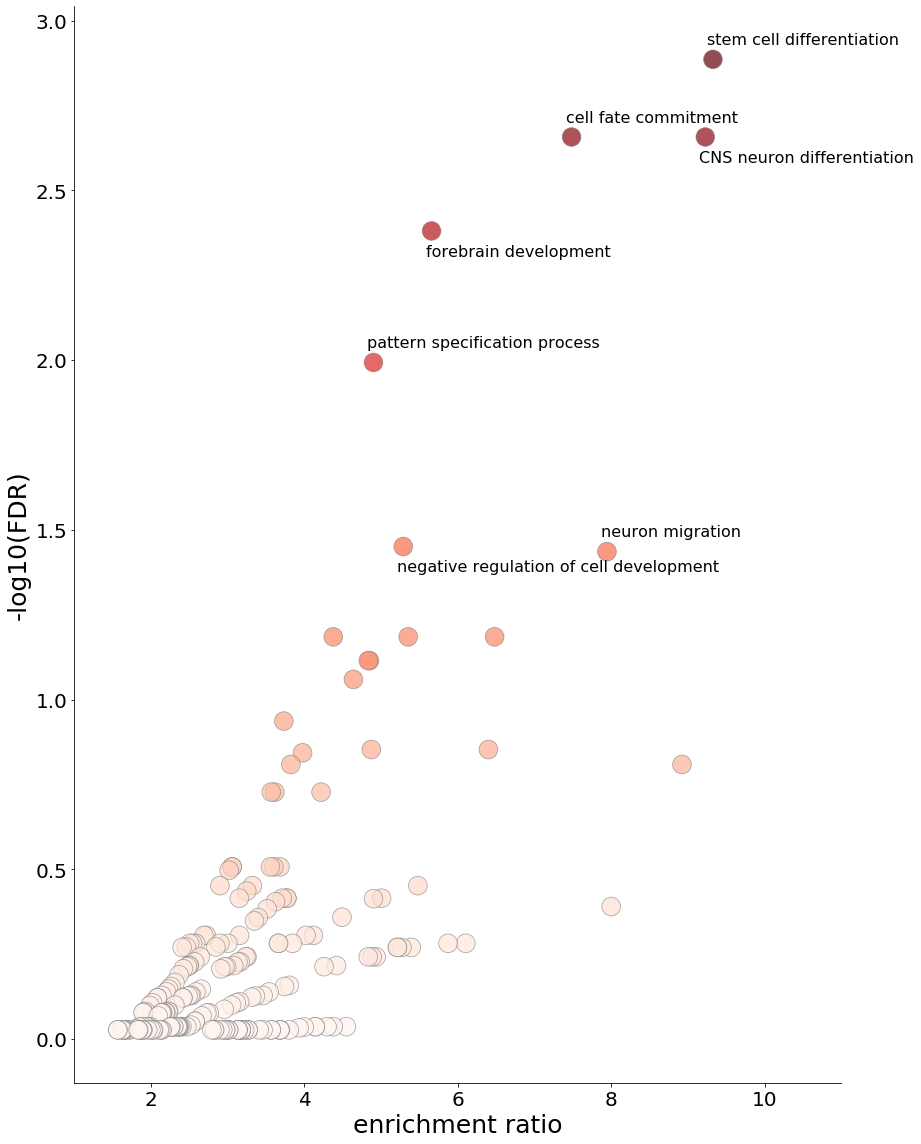

In [125]:
# Figure 2A
# using results from WebGestalt with following parameters: 
#   - test set = GO/positive_genes.txt
#   - reference set = data/all_genes.txt
#   - enrichment category = geneontology_Biological_Process_noRedundant
#   - minimum number of genes per category = 50

go_results = pd.read_csv('../results/GO/enrichment_results_webgestalt_postive_genes_allbackground.txt', delimiter='\t')

# select data for plot
plot_data = go_results.loc[:,['description', 'enrichmentRatio', 'FDR']].copy()
plot_data['-log10(FDR)']=-np.log10(plot_data['FDR']).values
fig, ax = plt.subplots(figsize=(13,16))

# volcano plot
sns.scatterplot(x='enrichmentRatio', y='-log10(FDR)', data=plot_data,
                hue='-log10(FDR)', palette='Reds', s=350, ax=ax, legend=None, edgecolor='grey', alpha=.7)

plt.xlim(1,11)
#plt.ylim(0,3.5)
ax.set_xlabel('enrichment ratio', fontsize=25)
ax.set_ylabel('-log10(FDR)', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)

# add labels to significant terms
sig_data = plot_data[plot_data['FDR']<0.05].copy()
# replace long name
sig_data['description'].replace('central nervous system neuron differentiation', 'CNS neuron differentiation', inplace=True)
extra = [15,-25]*round(len(sig_data)/2)
extra = extra[:len(sig_data)]
sig_data.loc[:,'pos'] = extra

for k in np.arange(len(sig_data)):
    title=sig_data['description'][k]
    xtext = sig_data['enrichmentRatio'][k]
    ytext = sig_data['-log10(FDR)'][k]
    ax.annotate(title, # this is the text
                 (xtext,ytext), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-6, sig_data['pos'][k]), # distance from text to points (x,y)
                 ha='left', fontsize=16)

sns.despine()

plt.tight_layout()
plt.savefig('Figure_2/Figure_2A.png')

current order: 
['fCPdli', 'fCPdlo', 'fCPm1i', 'fCPm1o', 'fCPvli', 'fCPvlo', 'pCPpvi', 'pCPpvo', 'pCPs1i', 'pCPs1o']
new order: 
['fCPdli', 'fCPdlo', 'fCPvli', 'fCPvlo', 'pCPpvi', 'pCPpvo', 'fCPm1i', 'fCPm1o', 'pCPs1i', 'pCPs1o']


/home/gball/PROJECTS/babyBrains/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


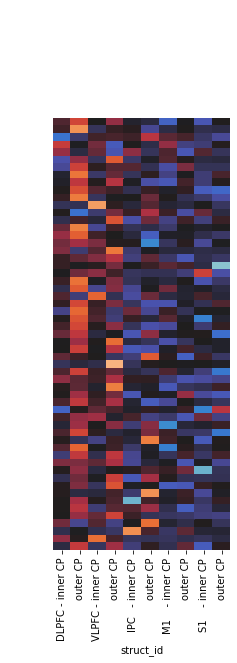

In [126]:
# Figure 2C - LMD microarray
# load LMD expression data for genes in PC1+ list
lmd_data = pd.read_csv('../data/validation/lmd-expression-matched-positive-genes.csv')

# average across donor samples
average_lmd_data = lmd_data.groupby(['struct_id']).mean().T

# reorder
print('current order: \n{:}'.format(list(average_lmd_data.columns)))
# new order 
order = [0,1,4,5,6,7,2,3,8,9]
print('new order: \n{:}'.format(list(average_lmd_data.columns[order])))

# plot
g = sns.clustermap(average_lmd_data.iloc[:,order],
                   row_cluster=False, metric='seuclidean',
                   col_cluster=False, z_score=0, cmap='icefire',
                   figsize=(4,10), vmin=-3, vmax=3, cbar_kws={"shrink": 0.5},
                   yticklabels=False,
                   xticklabels=['DLPFC - inner CP','        outer CP',
                               'VLPFC - inner CP','        outer CP',
                               'IPC   - inner CP','        outer CP',
                               'M1    - inner CP','        outer CP',
                               'S1    - inner CP','        outer CP',])
# remove colourbar
g.cax.set_visible(False)

# save
plt.tight_layout()
plt.savefig('Figure_2/Figure_2C.png')

permutations:   2%|▏         | 153/10000 [00:00<00:06, 1527.22it/s]


number of shared genes = 57/71
mean differential expression = 1.362

performing 10000 permutations: mean DE from 57 genes selected at random


permutations: 100%|██████████| 10000/10000 [00:06<00:00, 1447.57it/s]


p value = 0.00020


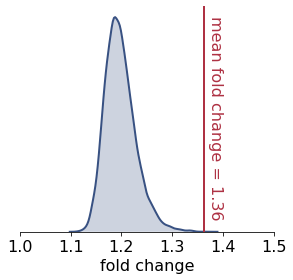

In [127]:
# Figure 2C - inset
n_perm = 10000

# load LMD differential expression data
lmd_data = pd.read_csv('../data/validation/lmd-differential-expression.csv')

# load significant genes
sig_genes = pd.read_csv('../results/gene_correlations/PCA_correlations-KendallTau-PC-significant_genes-p0.05.csv')

# calculate mean LMD differential expression in PC+ genes
shared_data = lmd_data[lmd_data['gene-symbol'].isin(list(sig_genes[sig_genes['PC1_tau']>0]['symbol']))]
mean_DE = shared_data['fold-change'].mean()

print('')
print('number of shared genes = {:}/{:}'.format(len(shared_data), len(sig_genes[sig_genes['PC1_tau']>0])))
print('mean differential expression = {:.3f}'.format(mean_DE))

# perform permutations - testing mean differential expression in genes selected at random
print('')
print('performing {:} permutations: mean DE from {:} genes selected at random'.format(n_perm, len(shared_data)))
p_mean_de = []
for p in trange(n_perm, desc='permutations'):
    idx = np.arange(len(lmd_data))
    np.random.shuffle(idx)
    # select random n genes from DE data
    p_data = lmd_data.iloc[idx[:len(shared_data)],:]
    # mean DE in random genes
    p_mean_de.append(p_data['fold-change'].mean())

p_value = (sum(np.array(p_mean_de)>mean_DE)+1)/(n_perm+1)
print('p value = {:.5f}'.format(p_value))

# plot results
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.distplot(p_mean_de, hist=False, kde_kws={'lw':2, 'color':'#385182', 'shade':True}, ax=ax)
ax.axvline(mean_DE, lw=2, color='#ae3143')
ax.text(1.37, 1, 'mean fold change = {:.2f}'.format(mean_DE), rotation=-90, fontsize=16, color='#ae3143')
ax.set_xlim(1,1.5)
ax.set_xlabel('fold change', fontsize=16)
sns.despine(left=True)
ax.tick_params('x', labelsize=16)
ax.set_yticklabels('')
ax.set_yticks([])

plt.tight_layout()
plt.savefig('Figure_2/Figure_2C-inset.png')

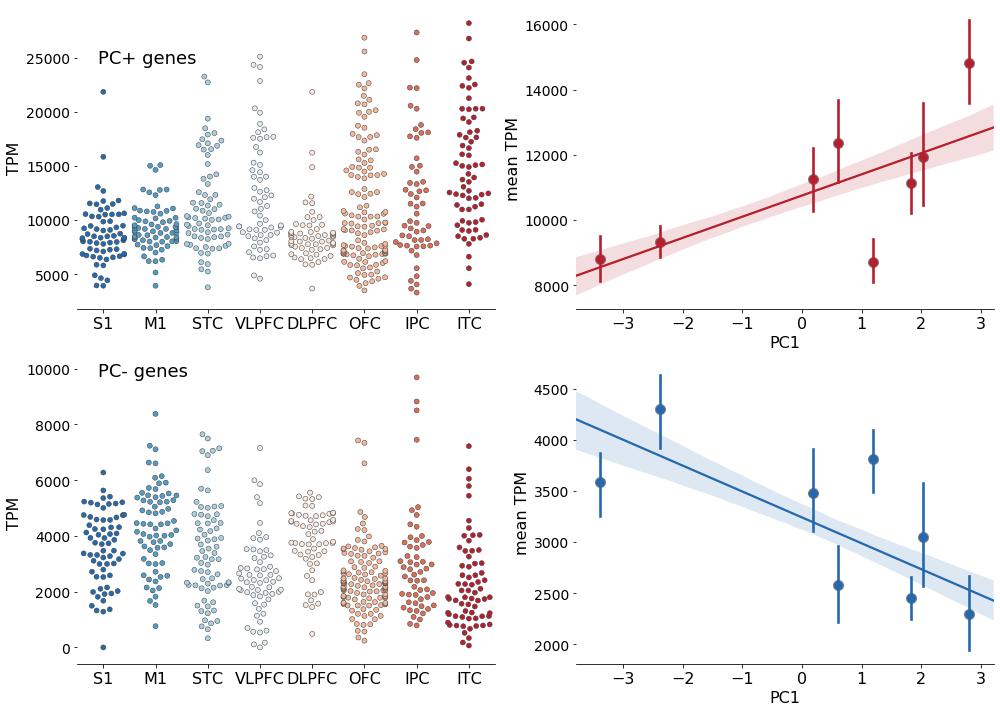

In [128]:
# Figure 2D - scRNA
# load processed scRNA data
cell_data = pd.read_csv('../data/validation/scRNA-TPM-data-scRNA-filtered.csv')

# load significant genes
sig_genes = pd.read_csv('../results/gene_correlations/PCA_correlations-KendallTau-PC-significant_genes-p0.05.csv')

# select genes in scRNA data that are also in PC+ gene lists
positive_gene_cell_data = cell_data.loc[cell_data['symbol'].isin(list(sig_genes[sig_genes['PC1_tau']>0]['symbol'])),:]
positive_gene_cell_data = positive_gene_cell_data.reset_index().drop('index', axis='columns')

# select genes in scRNA data that are also in PC- gene lists
negative_gene_cell_data = cell_data.loc[cell_data['symbol'].isin(list(sig_genes[sig_genes['PC1_tau']<0]['symbol'])),:]
negative_gene_cell_data = negative_gene_cell_data.reset_index().drop('index', axis='columns')

# load principal component data
pc = pd.read_csv('../results/PCA/mean-regional-principal-components.csv')

# for each cell, calculate the total TPM for all positive genes
# (each cells TPM will add up to 1mio for all genes, so this represents a measure of relative exp. for the gene set)
positive_cell_sum = positive_gene_cell_data.groupby(['new_region','cell']).sum().reset_index()
# add PC coordinates to cell data
positive_cell_sum['pc'] = positive_cell_sum['new_region'].map(dict(zip(pc['region'], pc['PC1'])))

# same for negative
negative_cell_sum = negative_gene_cell_data.groupby(['new_region','cell']).sum().reset_index()
# add PC coordinates to cell data
negative_cell_sum['pc'] = negative_cell_sum['new_region'].map(dict(zip(pc['region'], pc['PC1'])))

# plot
# order by PC1
order = np.argsort(positive_cell_sum.groupby('new_region').mean()['pc']).values
order = positive_cell_sum.groupby('new_region').mean().index[order]

fig, (ax1, ax2) = plt.subplots(2,2,figsize=(14,10), sharey=False)

# plot TPM of +ve genes for all cells
sns.swarmplot(x='new_region', y='TPM', data=positive_cell_sum, ax=ax1[0], hue='pc', order=order, palette='RdBu_r', linewidth=.5)
sns.regplot(x='pc', y='TPM', data=positive_cell_sum,
            x_estimator=np.mean, ax=ax1[1], color='#b61f2e', ci=95,n_boot=1000,
            scatter_kws={'s':100, 'edgecolor':'grey','zorder':1})
ax1[0].get_legend().remove()

# plot TPM of -ve genes for all cells
sns.swarmplot(x='new_region', y='TPM', order=order, data=negative_cell_sum, ax=ax2[0], palette='RdBu_r', linewidth=.5)
sns.regplot(x='pc', y='TPM', data=negative_cell_sum,
            x_estimator=np.mean, ax=ax2[1], color='#2469ad', ci=95,n_boot=1000,
            scatter_kws={'s':100, 'edgecolor':'grey','zorder':1})

sns.despine(left=True)
for ax in (ax1, ax2):
    ax[0].tick_params('x', labelsize=16)
    ax[0].tick_params('y', labelsize=14)
    ax[0].set_ylabel('TPM', fontsize=16)
    ax[0].set_xlabel('')

    ax[1].tick_params('x', labelsize=16)
    ax[1].tick_params('y', labelsize=14)
    ax[1].set_ylabel('mean TPM', fontsize=16)
    ax[1].set_xlabel('PC1', fontsize=16)

ax1[0].text(-.1,24500,'PC+ genes', fontsize=18)
ax2[0].text(-.1,9750,'PC- genes', fontsize=18)

plt.tight_layout()
plt.savefig('Figure_2/Figure_2D.png')